In [4]:
import os
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt

from src.train.rldataset import MsgVecDataset
from src.config import HOST_CONFIG, MODEL_CONFIGS

brain_config = MODEL_CONFIGS["basic-brain-test1"]
cache = MsgVecDataset(os.path.join(HOST_CONFIG.RECORD_DIR), brain_config)

groups = cache.groups
print(f"Found {len(groups)} groups")

#group = next(g for g in groups if g[0].get_runname() == "alphalog-5ef54ef2")
group = next(g for g in groups if g[0].get_runname() == "alphalog-4425c446")

print(f"Group {group[0].get_runname()} has {len(group)} logs")

samples = list(cache.generate_log_group(group, shuffle_within_group=False))

print(f"Num samples in group: {len(samples)}")


Found 89 groups
Group alphalog-4425c446 has 8 logs
obs 0 "odriveFeedback.leftMotor.vel"
  -0.045
  -0.095
  -0.145
  -0.195
  -0.246
obs 1 "odriveFeedback.leftMotor.current"
  -0.045
  -0.095
  -0.145
obs 2 "odriveFeedback.rightMotor.vel"
  -0.045
  -0.095
  -0.145
  -0.195
  -0.246
obs 3 "odriveFeedback.rightMotor.current"
  -0.045
  -0.095
  -0.145
obs 4 "voltage.volts"
  -0.045
obs 5 "headFeedback.pitchAngle"
  -0.013
  -0.046
  -7243.623
  -7243.623
  -7243.623
obs 6 "headFeedback.pitchMotorPower"
  -0.013
  -0.046
  -7243.623
obs 7 "headFeedback.yawAngle"
  -0.013
  -0.046
  -7243.623
  -7243.623
  -7243.623
obs 8 "headFeedback.yawMotorPower"
  -0.013
  -0.046
  -7243.623
obs 9 "odriveCommand.desiredVelocityLeft"
  -7243.623
  -7243.623
  -7243.623
  -7243.623
  -7243.623
obs 10 "odriveCommand.desiredVelocityRight"
  -7243.623
  -7243.623
  -7243.623
  -7243.623
  -7243.623
obs 11 "headCommand.pitchAngle"
  -7243.623
  -7243.623
  -7243.623
  -7243.623
  -7243.623
obs 12 "headComm

{'obs': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'reward': 0.019260942935943604, 'reward_override': False, 'key': 'alphalog-4425c446-42', 'done': False, 'act': array([ 0.        ,  0.        , -0.08302033,  0.13995218], dtype=float32), 'next_obs': array([0.        , 0.        , 0.        , ..., 0.25553608, 0.28219414,
       0.2920401 ], dtype=float32)}


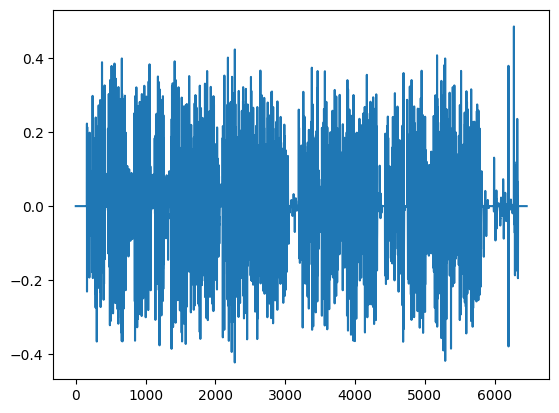

In [19]:

# Plot an action from each sample
print(samples[0])
plt.plot([s["act"][0] for s in samples])


<BarContainer object of 100 artists>

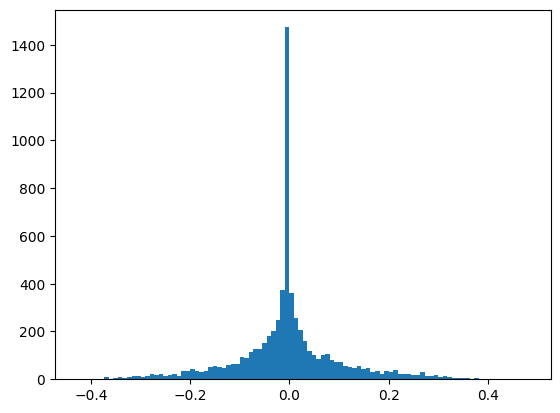

In [20]:
# Plot histogram of an action from each sample
counts, bins = np.histogram([s["act"][0] for s in samples], bins=100)

plt.bar(bins[:-1], counts, width=np.diff(bins))

In [64]:
# Get an instance of the brain model, and see the actions when you feed in slightly perturbed observations
import onnxruntime
from src.train.modelloader import create_and_validate_onnx
onnx_path = create_and_validate_onnx(brain_config)

sess = onnxruntime.InferenceSession(onnx_path)

index = 400

sample_orig = np.copy(samples[index]["obs"])
sample_mod = np.copy(samples[index]["obs"])
print(sample_orig.shape)
sample_mod[13451] -= 0.05

# Add random noise to sample_mod
#sample_mod += np.random.normal(0, 0.2, sample_mod.shape)

orig_outputs = sess.run(["action"], {"observation": sample_orig.reshape(1, -1)})
mod_outputs = sess.run(["action"], {"observation": sample_mod.reshape(1, -1)})

print("Orig", orig_outputs[0])
print("Modified", mod_outputs[0])

Found cached ONNX model /media/storage/robotaicache/models/basic-brain-test1-sb3-run78-3f8731a8921ddcff_orig.onnx
PT-ONNX Output 0 matches: 100.000%
(34229,)
Orig [[ 0.0464166   0.18105426  0.01344312 -0.11578909]]
Modified [[ 0.04636553  0.18113191  0.01352946 -0.11575501]]


In [22]:
# Recalculate all of the actions for the group
actions = []
for sample in samples:
    outputs = sess.run(["action"], {"observation": sample["obs"].reshape(1, -1)})
    actions.append(outputs[0][0])

-0.4993848 0.5071335


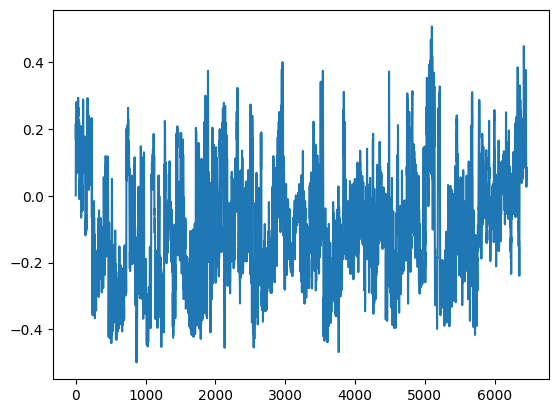

In [23]:
# Now, show the histogram of the actions again
counts, bins = np.histogram([a[3] for a in actions], bins=100)

print(min([a[0] for a in actions]), max([a[0] for a in actions]))


plt.plot([a[0] for a in actions])
#plt.bar(bins[:-1], counts, width=np.diff(bins))

[-0.15005752  0.07742853  0.06725074  0.06387421]
[ 0.21066809 -0.05781877 -0.00022161 -0.0523628 ]

[ 0.05538427  0.20295376  0.03411258 -0.15536158]
[ 0.16884279  0.12266338  0.00517917 -0.12055904]


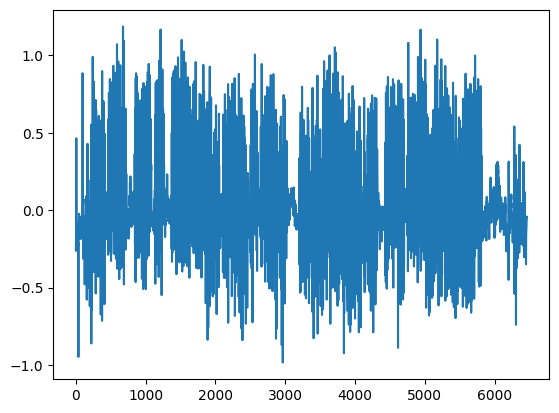

In [26]:
print(actions[396])
print(samples[396]["act"])
print()
print(actions[401])
print(samples[401]["act"])

# Plot difference of sample and actions
plt.plot([a[3] - s["act"][3] for a, s in zip(actions, samples)])

In [42]:
# Load the pytorch version of the model
import torch
from src.train.modelloader import create_pt_model
from src.models.stable_baselines3.sac import CustomSAC

full_model = CustomSAC.load(brain_config["checkpoint"])

inp = torch.from_numpy(samples[396]["obs"].reshape(1, -1)).to("cuda")
full_model.actor(inp, deterministic=True)

tensor([[-0.1501,  0.0774,  0.0673,  0.0639]], device='cuda:0',
       grad_fn=<TanhBackward0>)

In [36]:
# Check how much variance there is in the critic
full_model.critic(inp, full_model.actor(inp, deterministic=False))

(tensor([[-111.8246]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-111.3141]], device='cuda:0', grad_fn=<AddmmBackward0>))